In [20]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import tifffile as tf
from sklearn.cluster import KMeans

In [21]:
# Load the image
image = tf.imread('/content/peppers_color.tif')
height, width, channels = image.shape
print(height, width, channels)

512 512 2


In [22]:
# Reshape the image into a feature matrix
X = image.reshape(-1, channels)

In [23]:
# Set the number of Gaussian components
K = 3
# Regularization parameter
epsilon = 1e-6

In [15]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
means = kmeans.cluster_centers_
covs = [np.cov(X[kmeans.labels_ == k].T) for k in range(K)]
weights = np.ones(K) / K

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
# EM algorithm
max_iter = 100
log_likelihoods = []


In [17]:
for i in range(max_iter):
    # E-step: Calculate the responsibilities
    responsibilities = np.zeros((X.shape[0], K))
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k] + epsilon*np.eye(channels))
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

    # M-step: Update the parameters
    N = X.shape[0]
    new_weights = np.sum(responsibilities, axis=0) / N
    new_means = np.dot(responsibilities.T, X) / np.sum(responsibilities, axis=0, keepdims=True).T
    new_covs = [np.zeros((channels, channels)) for _ in range(K)]
    for k in range(K):
        diff = X - new_means[k]
        new_covs[k] = np.dot((responsibilities[:, k] * diff.T), diff) / np.sum(responsibilities[:, k])

    # Calculate the log-likelihood
    log_likelihood_vals = np.array([weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k] + epsilon*np.eye(channels)) for k in range(K)]).T
    log_likelihood = np.sum(np.log(np.sum(log_likelihood_vals, axis=1)))
    log_likelihoods.append(log_likelihood)

    # Check for convergence
    if i > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-6:
        break

    # Update the parameters
    means = new_means
    covs = new_covs
    weights = new_weights

In [18]:
# Perform segmentation
segmentation = np.argmax(responsibilities, axis=1).reshape(height, width)


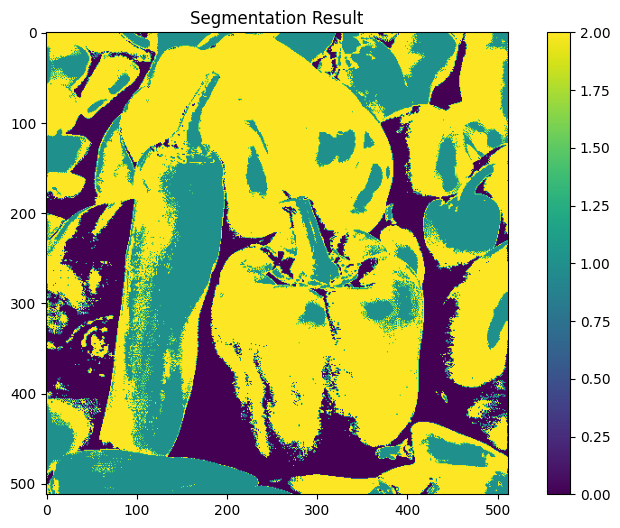

In [19]:
# Visualize the segmentation result
plt.figure(figsize=(10, 6))
plt.imshow(segmentation, cmap='viridis')
plt.title('Segmentation Result')
plt.colorbar()
plt.show()